# Text Preprocessing

In this notebook I preprocess raw `.txt` files, obtained from the previous step ([File Processing](./File_Processing.ipynb)).

I do two changes:
1. Cut out the title and contents pages by splitting the text on `Введение`
2. Cut out Bibliography/References

and show how it affects the volume of my data.

#### All imports

In [19]:
import json

import os
import re

import matplotlib.pyplot as plt

#### Corrupted files

In [20]:
with open('vkrs.json', 'r', encoding='utf-8') as v:
    vkrs = json.load(v)


lit_mast = [f"{v['vkr_id']}.txt" for v in vkrs if v['learn_program_title'] == 'Литературное мастерство']

In [21]:
eng = [
    '228418157.txt',
    '296294610.txt',
    '413235300.txt',
]

blank = [
    '296280186.txt', ## понять почему
]

corrupted = eng + blank + lit_mast
len(corrupted)

29

Files with no bibliography

In [8]:
no_lit = ['182863373.txt', '206736428.txt', '206746223.txt', '206746343.txt', 
          '206746957.txt', '206747365.txt', '206747703.txt', '206755543.txt', '366645295.txt']

#### Manual changes needed

`153009796` - delete `[ГЛАВА 3. ВОПРОСЫ ИГРОВОЙ МЕХАНИКИ] ВВЕДЕНИЕ` [184]

`153015091` - delete `[2. Глава 1. Теоретическое] введение` [41]

`206751554` - replace `Вступление` for `Введение` (понять почему не распарсился титулник и оглавление)

`206753739` - replace `Актуальность` for `Введение`

`206755431` - add space and delete newline after `открывает следующее введение:`

`206755839` - add `Введение` after `Москва 2017`

`219832572` - add newline in `Введение. Андрей Белый и геометрия.`

`296295072` - delete `[Введение] в проблематику`

`368169307` - fix typo `Ведение`

`370030380` - replace `Аннотация` for `Введение`

`153009491` - replace `| БИБЛ  |` for `БИБЛИОГРАФИЯ`

`153014521` - delete `Цитируемая литература`

`182307950` - delete `Исследовательская литература:`

`206756281` - delete newline after [15]th line (between `литература` and `в кросс-культурной`)

`206731223` - replace `Список литературы и источников` for `Список использованных источников и литературы`

`206745315` - replace `ЛИТЕРАТУРА` for `Библиография` [418]

`206747703` - delete `Список источников и литературы `

`206748102` - replace `Список использованной литературы и источников` for `Список использованных источников и литературы`

`206748500` - replace `Примечания` for `Список использованных источников и литературы` [220]

`206752914` - replace `СПИСОК ЛИТЕРАТУРЫ И ИСТОЧНИКОВ` for `Список использованных источников и литературы`

`206755827` - replace `Библиографическое описание` for `Библиографический список`

`219524491` - replace `Источники` for `Библиография` [365]

`219584449` - replace `СПИСОК ИСТОЧНИКОВ И ЛИТЕРАТУРЫ` for `Список использованных источников и литературы`

`220041648` - replace `Список литературы и источников` for `Список использованных источников и литературы` [441]

`366242236` - replace `Список источников и критической литературы` for `Список использованных источников и литературы`

`368409348` - replace `Список источников и литературы` for `Список использованных источников и литературы`

`368892792` - replace `Литература` for `Библиография` [249]

`369848996` - replace `Список источников и литературы` for `Список использованных источников и литературы`


`182863373, 206736428, 206746223, 206746343, 206746957, 206747365, 206747703, 206755543, 366645295` - no bibliography (иногда просто нет, иногда не распарсилась из .docx, так что могут быть приложения)

# Main functions

In [61]:
def get_text(file, folder):
    with open(os.path.join(folder, file), 'r', encoding='utf-8') as f:
        text = f.read()
    
    text = text.replace('\xa0', ' ')
    return text

In [62]:
def find_boundary(pattern, text, position='last', log=None):
    
    """
    Takes a compiled re pattern and searches for all it matches in a text,
    than takes the last found instance.
    
    Returns the index of the last character if position is set to 'last', 
    otherwise returns the index of the first character.
    Returns None if nothing was found.
    
    If log is an integer, prints out the context from i-log to i+log.
    """
    
    i = None
    
    if position == 'last':
        match = [m.end() for m in re.finditer(pattern, text)]
        if len(match) == 0:
            i = None
        else:
            i = match[-1]
        
    else:
        match = [m.start() for m in re.finditer(pattern, text)]
        if len(match) == 0:
            i = None
        else:
            i = match[-1]
        
        
    if type(log) == int:
        if i is not None:
            print(text[i-log:i+log])
        else:
            print('not found')
        
    return i

## Introduction

In [63]:
intro_pattern = re.compile(r"введение.{0,1}\s*\d*\n", flags=re.IGNORECASE)

def find_start(text):
    
    i = find_boundary(intro_pattern, text, position='last')
    
    if i is None:
        i = 0
    
    return i

## References

In [64]:
biblio = re.compile(r"библиография.{0,1}\s*\d*\n", flags=re.IGNORECASE)
bib_list = re.compile(r"библиографический список.{0,1}\s*\d*\n", flags=re.IGNORECASE)

ref_lit_list = re.compile(r"список использованных источников и литературы.{0,1}\s*\d*\n", flags=re.IGNORECASE)

ref_list = re.compile(r"список \w{0,14} {0,1}источников.{0,1}\s*\d*\n", flags=re.IGNORECASE)
lit_list = re.compile(r"список \w{0,14} {0,1}литературы.{0,1}\s*\d*\n", flags=re.IGNORECASE)

ref = re.compile(r"источники.{0,1}\s*\d*\n", flags=re.IGNORECASE)
lit = re.compile(r"литература.{0,1}\s*\d*\n", flags=re.IGNORECASE)

bib_patterns = [biblio, bib_list, ref_lit_list, ref_list, lit_list]

In [65]:
def find_end(text, intro=None):
    
    # intro index is neded for excluding mentions in the 'contents' section
    if intro is None:
        intro = find_start(text)
    
    # first check the usual biblography names
    all_indexes = [find_boundary(p, text, position='first') for p in bib_patterns]
    res = [i for i in all_indexes if i is not None and i > intro]
    
    # if nothing was found try 'источники' and 'литература'
    if len(res) == 0:
        ref_lit = [find_boundary(p, t, position='last') for p in [ref, lit]]
        res = [i for i in ref_lit if i is not None and i > intro]
    
    # if nothing was found again, return full length as index
     # else take the earliest found index 
    if len(res) == 0:
        return len(t)
    else:        
        return min(res)

## Cutting

In [66]:
def cut_text(text):
    
    start = find_start(text)
    
    end = find_end(text, start)
    
    return text[start:end]

# For single file

In [67]:
raw_folder = './parsed_files'
processed_folder = './cut_texts'

def full_cut(file_id, input_folder, output_folder):
    
    file = f'{file_id}.txt'
    
    text = get_text(file, input_folder)
    
    main_text = cut_text(text)
    
    with open(os.path.join(output_folder, file), 'w', encoding='utf-8') as out:
        out.write(main_text)

In [68]:
# full_cut('206756115', raw_folder, processed_folder)

# Bulck file cutting

In [69]:
raw_folder = './parsed_files'
processed_folder = './cut_texts'

### Loading everything in

In [70]:
files = [f for f in os.listdir(path=raw_folder) if f not in corrupted]
len(files)

578

In [71]:
texts = []

for file in files:
    texts.append(get_text(file, raw_folder))
    
lengths = [len(t) for t in texts]
    
len(texts)

578

### Getting the boundaries

In [72]:
intros = []

for t, f in zip(texts, files):
    i = find_start(t)
    intros.append(i)
    if i == 0:
        print(f)
        print(t[:2000])
        print('-------------------')

In [73]:
ends = []

for t, f, intro in zip(texts, files, intros):
    
    i = find_end(t, intro)
    ends.append(i)
    
    if i == 0 and f not in no_lit:
        print(f)

### Cutting and writing files

In [74]:
main_texts = []

for text, file, start, end in zip(texts, files, intros, ends):
    main_text = text[start:end]
    main_texts.append(main_text)
    
    with open(os.path.join(processed_folder, file), 'w', encoding='utf-8') as out:
        out.write(main_text)

# EDA

## Main text in realtion to the whole raw document range

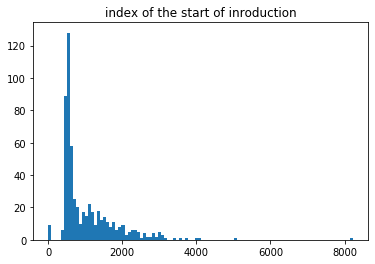

In [55]:
plt.hist(intros, bins=100)
plt.title('index of the start of inroduction')
plt.show()

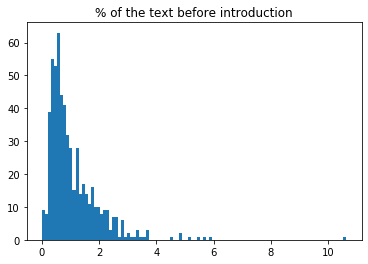

In [56]:
plt.hist([i*100/l for i,l in zip(intros, lengths)], bins=100)
plt.title('% of the text before introduction')
plt.show()

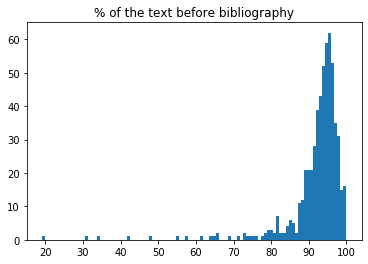

In [57]:
plt.hist([e*100/l for e,l in zip(ends, lengths)], bins=100)
plt.title('% of the text before bibliography')
plt.show()

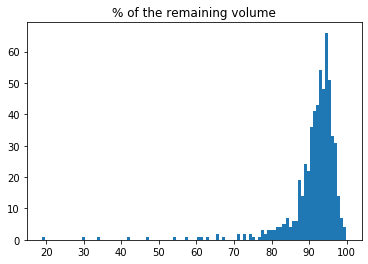

In [58]:
volumes = [(e-i)*100/l for i, e, l in zip(intros, ends, lengths)]

plt.hist(volumes, bins=100)
plt.title('% of the remaining volume')
plt.show()

Checking some suspicious cases

In [59]:
for t, f, v in zip(texts, files, volumes):
    if v < 50:
        print(f)

182795876.txt
219740682.txt
296307429.txt
366241709.txt
368722283.txt


In [60]:
for t, f, e, l in zip(texts, files, ends, lengths):
    percent = e*100/l
    if 0 < percent <= 40:
        print(t[e-100:e+100])
        print(f)
        print('----------')

 сложившуюся ситуацию не представляется возможным, в виду вышеперечисленных причин.
















Список литературы
Белая В. А. (2009) Профессия как социологическая категория: основные подходы к опр
182795876.txt
----------
е и практически может быть приложена к другим этническим традиционным культурам. 







Источники

Интервью с Г.Г. Абдрахмановой в Москве 29.04.2019. (Архив автора)
Интервью с А.А. Абдрахмановым в Мо
296307429.txt
----------
езусловная благодарность моей чудесной маме, которая мотивировала все мои лучшие победы.
Литература
Busse K. Framing Fan Fiction: Literary and Social Practices in Fan Fiction Communities, University o
366241709.txt
----------


*Anna Polyanskaya, 2021*